### Kalman-EM
---

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns
 
plt.style.use('ggplot')
%matplotlib inline

msefactor1    0.043745
msefactor2    0.001031
msefactor3    0.020747
msefactor4    0.024042
msefactor5    0.010685
dtype: float64

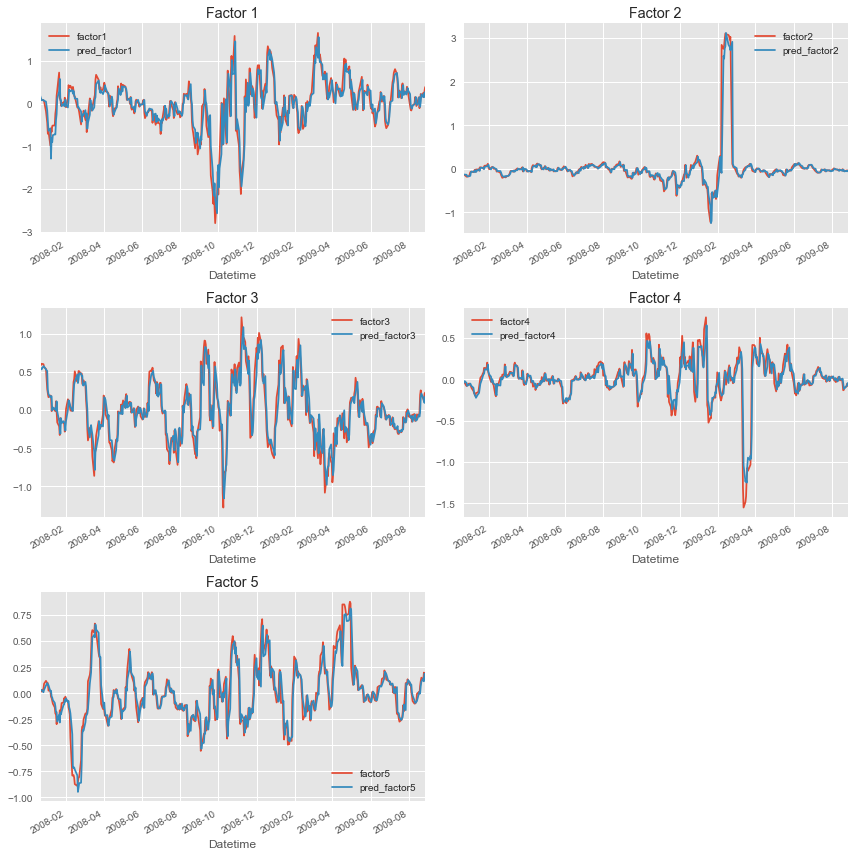

In [2]:
order=1
state=2
factor=pd.read_excel('./output/KalmanEM/r.xlsx')
pred=pd.read_excel('./output/KalmanEM/pf.xlsx')
p=pd.read_excel('./output/KalmanEM/p.xlsx')
factor['prob']=p[0]
for _ in pred.columns[1:]: 
    factor['pred_'+_]=pred[_]
factor['Datetime']=factor['Date']
factor.set_index('Datetime', inplace=True)

  
fig, axes=plt.subplots(nrows=3, ncols=2, figsize=(12,12))
factor[['factor1', 'pred_factor1']].plot(ax=axes[0,0], title='Factor 1')
for i, _ in  enumerate(pred.columns[2:]):
    factor[[_, 'pred_{}'.format(_)]].plot(ax=axes[(i+1)//2, (i+1)%2], title='Factor {}'.format(i+2))    
for i in range(len(pred.columns[1:])): 
    axes[i//2, i%2].spines['top'].set_visible(False) 
    axes[i//2, i%2].spines['right'].set_visible(False)
    axes[i//2, i%2].legend(frameon=False); 
axes[(i+1)//2, (i+1)%2].axis('off')
plt.tight_layout()
plt.savefig('./output/fig/pre_factor')


error=pd.DataFrame(index=factor.index)
for _ in pred.columns[1:]:
    error[_]=(factor['pred_'+_]-factor[_]).apply(lambda x: abs(x))
    error['bch_'+_]=(factor[_]-factor[_].shift(1)).apply(lambda x: abs(x))
    error['ret'+_]=error[_]/error['bch_'+_]
    error['pe'+_]=error[_]/factor[_].apply(lambda x:abs(x))
    error['mse'+_]=error[_]**2
et=error[['mse'+_ for _ in pred.columns[1:]]].iloc[-132:]
et.mean()

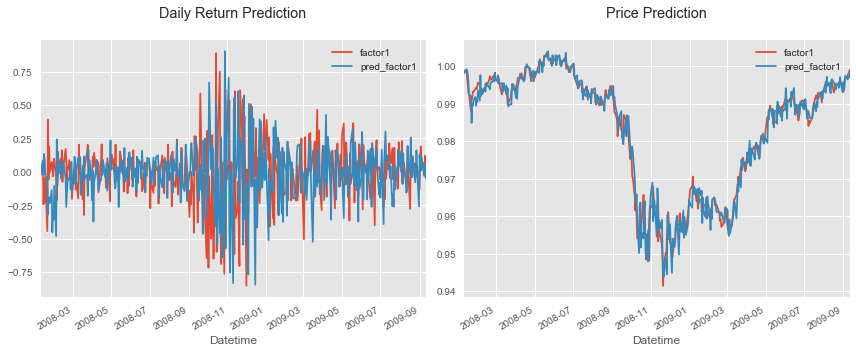

In [3]:
pred_df=pd.read_excel('./output/KalmanEM/pred_df.xlsx')
r_df=pd.read_excel('./output/KalmanEM/r_df.xlsx')
pred_rtn=pd.read_excel('./output/KalmanEM/pred_rtn.xlsx')
r_rtn=pd.read_excel('./output/KalmanEM/r_rtn.xlsx')

for _ in pred_df.columns[1:]:
    r_df['pred_'+_]=pred_df[_]
    r_rtn['pred_'+_]=pred_rtn[_]
r_df['Datetime']=r_df['Date']
r_df.set_index('Datetime', inplace=True)
r_rtn['Datetime']=r_rtn['Date']
r_rtn.set_index('Datetime', inplace=True)

fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(12,5))
r_rtn[['factor1', 'pred_factor1']].plot(ax=axes[0], title='Daily Return Prediction\n')
r_df[['factor1', 'pred_factor1']].plot(ax=axes[1], title='Price Prediction\n')  
for i in range(2): 
    axes[i].spines['top'].set_visible(False) 
    axes[i].spines['right'].set_visible(False)
    axes[i].legend(frameon=False); 
 

 
plt.tight_layout()
plt.savefig('./output/fig/DailyPred')


 
### Likelihood Function 

---

In [4]:
ob=pd.read_excel('./output/KalmanEM/r.xlsx')
ob=ob.iloc[-132:]
ob.set_index('Date', inplace=True)
k=len(ob.columns) #number of key factors 
ob.head()

,factor1,factor2,factor3,factor4,factor5
Date,,,,,
2009-02-24,0.044361,0.069860,-0.170882,-0.045951,-0.173460
2009-02-25,0.184999,0.031774,-0.064652,-0.040212,-0.262711
2009-02-26,0.226862,0.042385,-0.073110,0.042491,-0.103291
2009-02-27,0.261321,0.014029,-0.109972,0.129745,-0.074200
2009-03-02,0.893199,-0.088520,-0.294490,0.192976,-0.125456


In [5]:
def phi_k(t,  #time point 
          state, # number of states 
          s,  #current state
          args): #model parameters 
    from math import exp, sqrt, pi

    phi=1
    v1=ob.iloc[t].values
    v0=np.array([0.]*k) if t==0 else ob.iloc[t-1].values
    for i in range(k):
        phi*=(exp(-0.5*(v1[i]-args[i+s*k]*v0[i]-args[i+(s+state)*k])**2\
                  /args[i+(2*state+s)*k])/sqrt(2*pi*args[i+(2*state+s)*k]))
    return phi

def likelihood(state, args):
    '''
    args(e.g., state=2):
    =====
         p_ij: args[:4]=(pi_11, pi_12, pi_21, pi_22)
         kappa_i: args[4: 4+2*k]
         gamma_i: args[4+2*k:4+4*k]
         sigma_i^2: args[4+4*k:]
    '''
    from math import log
    
    if state>1:
        p=pd.read_excel('./output/KalmanEM/p.xlsx')
        p=p.iloc[-132:]
        p.reset_index(inplace=True)
        p=p[p.columns[2:]]      
        pt=p.iloc[0]
        f_t=[]
        for i in range(state):
            f_t.append(pt[i]*phi_k(0,state, i, args.iloc[0].values[state**2:]))
        ft=sum(f_t)
        llh=log(ft+0.000001)
        for t in range(1, 132):
            f_t=[]
            pt=p.iloc[t]
            for i in range(state):
                for j in range(state):
                    temp=pt[i]*args.iloc[t].values[i*state+j]*phi_k(t, state,  j, args.iloc[t].values[state**2:])
                    f_t.append(temp)
            ft=sum(f_t)
            llh+=log(ft+0.000001)
        return llh
    else:
        ft=phi_k(0,state, 0, args.iloc[0].values[1:])
        llh=log(ft+0.000001)
        for t in range(1, 132):
            ft= phi_k(t, state,  0, args.iloc[t].values[1:])
            llh+=log(ft+0.000001)
        return llh


In [6]:
#two-state likelihood
mp2=pd.read_excel('./output/KalmanEM/modp.xlsx')
mp2.set_index(mp2.columns[0], inplace=True)
mp2.index.name=None
args2=mp2
args2=args2.iloc[-132:]
llh2=likelihood(2, args2)
llh2

521.3653881991494

---